In [19]:
from dotenv import load_dotenv
import os
import wandb
import tarfile
import os
import shutil

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from itertools import cycle

from tqdm.notebook import tqdm

from collections import namedtuple

In [20]:
# Load .env file
load_dotenv()

# Access the API key
# api_key = os.getenv("WANDB_API_KEY")
api_key = "4140c08ae9644450d5f09dbdff386b71e689b04c"
wandb.login(key=api_key)

api = wandb.Api(timeout=60)

entity = "j4b"        # Your WandB username or team name
project = "rl-battery-management" # Your WandB project name
run_id = "9et6b3zy" # 7a9k98t4 "f8l4u7x4" # "waj0fjc3"  9et6b3zy  prhn0gl1     # ID of the specific run 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\zm0714\_netrc


In [21]:
# 20cs no_charge_in_breaks: 5ci1627k
# 4cs: smng8nfs
# 20cs charge_in_breaks (eval only): 5qdjkxob
# 20cs charge_in_breaks (train): q7y9vy3q
# Specify your project and run ID
# tpt: [0, 2, 4,..., 12] ept: 10: 2qemex9x

# Retrieve the run object
run = api.run(f"{entity}/{project}/runs/{run_id}")

In [22]:
n_cs = 3
n_partitions = 14
tar_name = 'experiment_data3'
root_dir = f'./result_data_charging_wepa/charging_strat_comp'
root_dir_extraction = f'{root_dir}/result_data_remote3'

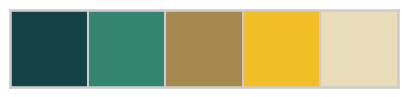

In [23]:
sns.set_style("whitegrid")
sns.set_context("talk")

hex_colors = ['#144246',
              #'#69657e',
              '#338470',
              '#a6874e',
              #'#FFFF33', '#FFD801', '#FFDF00',
              '#f2be25', '#e8dcb9']
pal = sns.color_palette(hex_colors, desat=1)
sns.palplot(pal)

In [24]:
shortnames = {
    'COL': 'COL',
    ' COL': 'COL',
    ' CTD': 'CTD',
    ' CTNR': 'CTNR',
    ' SL': 'SL',
    ' SLO': 'SLO',
    'RND':'RND',
    'allOrdersPopularity_future_z2': 'AOPF2',
    'allOrdersPopularity_future_z3': 'AOPF3',
    'allOrdersPopularity_future_z5': 'AOPF5',
    'allOrdersPopularity_past_z2': 'AOPP2',
    'allOrdersPopularity_past_z3': 'AOPP3',
    'allOrdersPopularity_past_z5': 'AOPP5',
    'classBasedCycleTime_z2': 'CBCT2',
    'classBasedCycleTime_z3': 'CBCT3',
    'classBasedCycleTime_z5': 'CBCT5',
    'retrievalPopularity_future_z2': 'ROPF2',
    'retrievalPopularity_future_z3': 'ROPF3',
    'retrievalPopularity_future_z5': 'ROPF5',
    'retrievalPopularity_past_z2': 'ROPP2',
    'retrievalPopularity_past_z3': 'ROPP3',
    'retrievalPopularity_past_z5': 'ROPP5',
    'VeryGreedy COL': 'GCOL',
    'DQN': 'COL',
    'SAC': 'SAC'
}

In [25]:
def order_files(src_dir):
    files = os.listdir(src_dir)
    pbar = tqdm(total=len(files))
    for i in range(len(files)):
        f_name = files[i]
        print(f_name)
        if not f_name.endswith('.csv') or 'actions' in f_name:
            continue
        segs = f_name.split('_')
        pt = segs[1]
        charging_policy = segs[3]
        th = segs[4]
        name = segs[3]
        # new_name = shortnames[name]
        interrupted = segs[5]
        orders = f'{int(segs[-1].split(".")[0]):06}'
        tgt_dir = f'{src_dir}/partition_{pt}/{th}/{interrupted}/{name}/'
        if not os.path.exists(tgt_dir):
            os.makedirs(tgt_dir)
        shutil.move(f'{src_dir}/{f_name}',
                    f'{tgt_dir}/{orders}.csv')
        pbar.update(1)
order_files(root_dir)

  0%|          | 0/25 [00:00<?, ?it/s]

boxplot__kpi__average_service_time_ppo_rewards.png
boxplot__kpi__average_service_time_thresholds_per_week.png
boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png
boxplot__kpi__max_ret_buffer_per_week.png
boxplot__kpi__queued_retrieval_orders_ppo_rewards.png
boxplot__queued_retrieval_thresholds_vs_interrupt_per_week.png
fill_level_weeks.png
full_run
n_orders.png
partition_0
partition_1
partition_10
partition_11
partition_12
partition_13
partition_2
partition_3
partition_4
partition_5
partition_6
partition_7
partition_8
partition_9
ppo_ep_rewards.png
test


In [26]:
def load_storage_strategy_dataframe(data_root):
    n_zones = 3
    strategy_name = data_root.split('/')[4]
    interrupted = data_root.split('/')[5]
    go_charging = data_root.split('/')[6]
    # n_zones = int(strategy_name[-1]) if strategy_name[-1].isdigit() else 3
    if not os.path.exists(data_root):
        print(f"did not find path {data_root}; skipping...")
        return
    dfs = []
    csv_f_names = os.listdir(data_root)
    # pbar = tqdm(total=len(csv_f_names))
    print(f'Loading result files into dataframes for the '
          f'{strategy_name} simulation run...')
    for f_name in csv_f_names:
        if os.path.isdir(f'{data_root}/{f_name}') or f_name == '.DS_Store':
            #print(f'{data_root}/{f_name}')
            continue
        df_result_part = pd.read_csv(f'{data_root}/{f_name}', index_col=0)
        n_rows = df_result_part.shape[0]
        df_result_part['strategy_name'] = [f"{go_charging}_{strategy_name}_{interrupted}"] * n_rows
        df_result_part['n_zones'] = [n_zones] * n_rows
        df_result_part['interrupted'] = [interrupted] * n_rows
        df_result_part['go_charging'] = [go_charging] * n_rows

        dfs.append(df_result_part)
        # print(strategy_name, n_zones, order_set_nr)
        # pbar.update(1)
    strategy_df = pd.concat(dfs).reset_index(drop=True)
    strategy_df.name = f"{go_charging}_{strategy_name}_{interrupted}"
    return strategy_df

# dfs_d = dict({})
# n_agvs = 40
# for n_cs in range(1,9):
#     dfs_d[n_cs] = []
#     for shortname in shortnames.values():
#         df = load_storage_strategy_dataframe(
#             f'{root_dir}/n_agvs__{n_agvs}/n_cs__{n_cs}/{shortname}')
#         if df is not None:
#             dfs_d[n_cs].append(df)
dfs_d = dict({})
partitions = [i for i in range(n_partitions)]
thresholds = [30, 40, 50, 60, 70, 80, 90, 100, "R1", "R2", "R3", "R4"]
interrupted = ["False", "True"]
go_charging = ["FixedCharge", "Fixed", "Opportunistic", "PPO"]
for pt in partitions:
    print(f"Loading partition {pt}")
    dfs_d[pt] = []
    for th in thresholds:
        for interrupt in interrupted:
            for strat in go_charging:
                path = f'{root_dir}/partition_{pt}/th{th}/{interrupt}/{strat}'
                df = load_storage_strategy_dataframe(path)
                if df is not None:
                    dfs_d[pt].append(df)

Loading partition 0
Loading result files into dataframes for the th30 simulation run...
Loading result files into dataframes for the th30 simulation run...
Loading result files into dataframes for the th30 simulation run...
did not find path ./result_data_charging_wepa/charging_strat_comp/partition_0/th30/False/PPO; skipping...
Loading result files into dataframes for the th30 simulation run...
Loading result files into dataframes for the th30 simulation run...
Loading result files into dataframes for the th30 simulation run...
did not find path ./result_data_charging_wepa/charging_strat_comp/partition_0/th30/True/PPO; skipping...
Loading result files into dataframes for the th40 simulation run...
Loading result files into dataframes for the th40 simulation run...
Loading result files into dataframes for the th40 simulation run...
did not find path ./result_data_charging_wepa/charging_strat_comp/partition_0/th40/False/PPO; skipping...
Loading result files into dataframes for the th40 s

In [27]:
def gen_result_table(dfs_d, value, mode):
    list_of_dfs = []
    for idx in partitions:
        print("Loading partition", idx)
        # print(idx)
        df_results_pt = pd.DataFrame(columns=[f"{idx}"])
        for df in dfs_d[idx]:
            # print(df.name)
            # print(df["kpi__average_service_time"].mean())
            df = df.sort_values(by="kpi__makespan")
            if mode == "mean":
                row_data = pd.DataFrame(data={f"{idx}": [df[value].mean()]})  # df["kpi__makespan"].iloc[-1]]
            elif mode == "last":
                row_data = pd.DataFrame(
                    data={f"{idx}": [float(df[value].iloc[-1].round(decimals=2))]})  # df["kpi__makespan"].iloc[-1]]
            elif mode == "max":
                row_data = pd.DataFrame(data={f"{idx}": [df[value].max()]})
            # print(df["kpi__makespan"].iloc[-1])
            df_results_pt = pd.concat([df_results_pt, row_data])
        list_of_dfs.append(df_results_pt)
        print(len(df_results_pt))
    strategy_col = pd.DataFrame(columns=["Strategy"])
    for th in thresholds:
        row = pd.DataFrame(data={"Strategy": [th]})
        strategy_col = pd.concat([strategy_col, row])
    print(strategy_col)
    result_df = pd.DataFrame()
    result_df = pd.concat([result_df, strategy_col], axis=1)
    for df in list_of_dfs:
        result_df = pd.concat([result_df, df], axis=1)
    result_df = result_df.transpose().reset_index()
    new_header = result_df.iloc[0]
    result_df.drop(index=0, inplace=True)
    result_df.columns = new_header
    # result_df["Avg. overall"] = result_df.loc[:, [40, 50, 60, 70, 80, 90, 100, "no_battery_constraints"]].mean(axis = 1)
    # result_df["Std"] = result_df.iloc[:, 1:5].std(axis=1)
    # fill_lvl = [68, 87, 90, 77, 74, 86, 78, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    # result_df.insert(11, "Fill Level", fill_lvl, True)
    return result_df

In [28]:
Result = namedtuple('Result', [
    'total_distance',
    #     'average_distance',
    #     'travel_time_retrieval_ave',
    'total_shift_distance',
    'distance_retrieval_ave',
    'utilization_time',
    'makespan',
    'cycle_time',
    'entropy',
    'average_service_time',
    'max_average_service_time',
    'throughput', 
    'max_delivery_buffer', 'max_retrieval_buffer', 'mean_retrieval_buffer',
    'max_agv_depleted', 'mean_agv_depleted',
    'max_cs_queue', 'mean_cs_queue',
    'mean_battery_level',
    'index', 
    'name',
    'go_charging',
    'interrupted',
    'threshold'])


def get_best_storage_strategies(experiment_dfs, n_best, exclude, scoring='average_service_time'):
    scores = []
    idx = 0
    for df in experiment_dfs:
        df_sorted = df[[
            'total_distance',
            # 'average_distance',
            # 'travel_time_retrieval_ave',
            'total_shift_distance',
            'distance_retrieval_ave',
            'utilization_time',
            'kpi__makespan',
            'kpi__cycle_time',
            'entropy',
            'kpi__average_service_time',
            'kpi__throughput', 'n_finished_orders',
            'n_queued_delivery_orders',
            'n_queued_retrieval_orders', 
            'n_agv_depleted', 
            'n_queued_charging_events',
            'avg_battery_level']
        ].sort_values('kpi__makespan')
        if df.name == "th_no_battery_constraints":
            df_sorted.name = "lower bound"
        if df.name == "dqn" or df.name == "sac":
            df_sorted.name = df.name
        else:
            df_sorted.name = df.name  # .split("_")[1]

        end_row = df_sorted.iloc[-1, :]
        res = Result(
            end_row['total_distance'],
            # end_row['average_distance'],
            # end_row['travel_time_retrieval_ave'],
            end_row['total_shift_distance'],
            end_row['distance_retrieval_ave'],
            end_row['utilization_time'],
            end_row['kpi__makespan'],
            end_row['kpi__cycle_time'],
            end_row['entropy'],
            end_row['kpi__average_service_time'],
            df_sorted['kpi__average_service_time'].max(),
            end_row['kpi__throughput'],
            df_sorted['n_queued_delivery_orders'].max(),
            df_sorted['n_queued_retrieval_orders'].max(),
            df_sorted['n_queued_retrieval_orders'].mean(),
            df_sorted['n_agv_depleted'].max(),
            df_sorted['n_agv_depleted'].mean(),
            df_sorted['n_queued_charging_events'].max(),
            df_sorted['n_queued_charging_events'].mean(),
            df_sorted['avg_battery_level'].mean(),
            idx, 
            df_sorted.name,
            df_sorted.name.split('_')[0],
            df_sorted.name.split('_')[2],
            df_sorted.name.split('_')[1]
        )
        scores.append(res)
        idx += 1
    scores_sorted = sorted(scores, key=lambda x: getattr(x, scoring))
    df_selection = []
    n_best = min(n_best, len(scores_sorted))
    print(n_best)
    for i in range(n_best):
        res = scores_sorted[i]
        print(res.average_service_time, i, experiment_dfs[scores_sorted[i].index].name)
        df_selection.append(experiment_dfs[scores_sorted[i].index])
    print("done")
    res_df = pd.DataFrame(data=scores_sorted)
    return df_selection, res_df


best_dfs_d = dict({})
res_overview_df_d = dict({})
for pt, dfs_s in dfs_d.items():
    print(f"Heuristic Service Time Ranks for partition {pt}:")
    best_dfs_d[pt], res_overview_df_d[pt] = get_best_storage_strategies(
        dfs_s, 20, [], 'average_service_time')


# result_df_copy = result_df_copy.drop([30, 100], axis=1)



Heuristic Service Time Ranks for partition 0:
20
109.93624161073764 0 FixedCharge_th30_False
109.93624161073764 1 Fixed_th30_False
109.93624161073764 2 FixedCharge_th30_True
109.93624161073764 3 Fixed_th30_True
109.93624161073764 4 FixedCharge_th40_False
109.93624161073764 5 Fixed_th40_False
109.93624161073764 6 FixedCharge_th40_True
109.93624161073764 7 Fixed_th40_True
109.93624161073764 8 FixedCharge_th50_False
109.93624161073764 9 Fixed_th50_False
109.93624161073764 10 FixedCharge_th50_True
109.93624161073764 11 Fixed_th50_True
109.93624161073764 12 FixedCharge_th60_False
109.93624161073764 13 Fixed_th60_False
109.93624161073764 14 FixedCharge_th60_True
109.93624161073764 15 Fixed_th60_True
109.93624161073764 16 FixedCharge_th70_False
109.93624161073764 17 Fixed_th70_False
109.93624161073764 18 FixedCharge_th70_True
109.93624161073764 19 Fixed_th70_True
done
Heuristic Service Time Ranks for partition 1:
20
470.9284402511743 0 FixedCharge_th90_True
470.9284402511743 1 Fixed_th90_True

In [29]:
flattened_list = [res_overview_df_d[df_key] for df_key in res_overview_df_d.keys()]

In [30]:
for week_id, df in enumerate(flattened_list):
    df["week"] = week_id

In [31]:
strat_names = {"th100": "FULL", "thopportunity+": "OPP"}
def create_latex_table(df):
    latex = (
        "\\begin{table}[!h]\n"
        "\\setlength{\\tabcolsep}{2pt}\n"
        "\\scriptsize\n"
        "\\newcolumntype{C}{>{\\centering\\arraybackslash}X}\n"
        "\\begin{tabularx}{\\textwidth}{\n"
        ">{\\\raggedright\\arraybackslash}p{2cm}CCCCCC}\n"
        "\\toprule\n"
    )
    # Headers
    latex += ("\\multirow{2}{*}{\\textbf{Week}} & \\textbf{Strategy} & "
             "\\textbf{Avg Service Time (in s)} & \\textbf{Max Retrieval Queue} & "
             "\\textbf{Mean Retrieval Queue} & \\textbf{Max Depleted AMR} & "
             "\\textbf{Mean Depleted AMR} \\\\\n"
             "\\midrule\n")
    # Group by week and create rows
    for week, week_data in df.groupby('week'):
        first_row = True
        num_strategies = len(week_data)
        
        for _, row in week_data.iterrows():
            if first_row:
                latex += f"\\multirow{{{num_strategies}}}{{*}}{{{week}}} "
                first_row = False
            else:
                latex += "{} "
            if row["name"] in strat_names.keys():
                strat_name = strat_names[row['name']]
            else:
                strat_name = row["name"]
            latex += f"& {{\\textbf{{{strat_name}}}}} & "
            latex += f"\\makecell[c]{{{row['average_service_time']:.2f}}} & "
            latex += f"\\makecell[c]{{{row['max_retrieval_buffer']:.2f}}} & "
            latex += f"\\makecell[c]{{{row['mean_retrieval_buffer']:.2f}}} & "
            latex += f"\\makecell[c]{{{row['max_agv_depleted']:.2f}}} & "
            latex += f"\\makecell[c]{{{row['mean_agv_depleted']:.2f}}} \\\\\n"
        latex += "\\cmidrule(rr){1-1}\cmidrule(ll){2-7}\n"
    latex += """\\bottomrule
\\end{tabularx}
\\caption{\\small Results for the charging strategies comparison}
\\label{tab:results}
\\end{table}"""
    
    return latex
# Generate and print the LaTeX code
df_paper = pd.concat(flattened_list)
# df_paper.rename(columns={"thopportunity": "OPP", "th100": "FULL"}, inplace=True)
strat_subset = ["FixedCharge_th30_True", "FixedCharge_th40_True", "FixedCharge_th50_True","FixedCharge_th60_True","FixedCharge_th70_True", "FixedCharge_th80_True", "FixedCharge_th90_True", "FixedCharge_th100_True"]
strat_subset = ["Opportunistic_th30_True", "Opportunistic_th40_True", "Opportunistic_th50_True","Opportunistic_th60_True","Opportunistic_th70_True", "Opportunistic_th80_True", "Opportunistic_th90_True", "Opportunistic_th100_True"]
#df_paper = df_paper[df_paper["name"].isin(strat_subset)]
print(create_latex_table(df_paper))

\begin{table}[!h]
\setlength{\tabcolsep}{2pt}
\scriptsize
\newcolumntype{C}{>{\centering\arraybackslash}X}
\begin{tabularx}{\textwidth}{
aggedright\arraybackslash}p{2cm}CCCCCC}
\toprule
\multirow{2}{*}{\textbf{Week}} & \textbf{Strategy} & \textbf{Avg Service Time (in s)} & \textbf{Max Retrieval Queue} & \textbf{Mean Retrieval Queue} & \textbf{Max Depleted AMR} & \textbf{Mean Depleted AMR} \\
\midrule
\multirow{50}{*}{0} & {\textbf{FixedCharge_th30_False}} & \makecell[c]{109.94} & \makecell[c]{0.00} & \makecell[c]{0.00} & \makecell[c]{1.00} & \makecell[c]{0.00} \\
{} & {\textbf{Fixed_th30_False}} & \makecell[c]{109.94} & \makecell[c]{0.00} & \makecell[c]{0.00} & \makecell[c]{1.00} & \makecell[c]{0.00} \\
{} & {\textbf{FixedCharge_th30_True}} & \makecell[c]{109.94} & \makecell[c]{0.00} & \makecell[c]{0.00} & \makecell[c]{1.00} & \makecell[c]{0.00} \\
{} & {\textbf{Fixed_th30_True}} & \makecell[c]{109.94} & \makecell[c]{0.00} & \makecell[c]{0.00} & \makecell[c]{1.00} & \makecell[c]{0.00} 

In [32]:
df_paper = df_paper.replace("FixedCharge", "StateBased")

In [33]:
excluded = [f"Opportunistic_th{th}_{interrupted}" for interrupted in ["True", "False"] for th in [30, 40, 50, 60, 70, 80, 90]]
excluded.extend([f"FixedCharge_th{th}_{interrupted}" for interrupted in ["True", "False"] for th in [30, 50, 60, 70, 80, 90, 100]])

In [34]:
excluded

['Opportunistic_th30_True',
 'Opportunistic_th40_True',
 'Opportunistic_th50_True',
 'Opportunistic_th60_True',
 'Opportunistic_th70_True',
 'Opportunistic_th80_True',
 'Opportunistic_th90_True',
 'Opportunistic_th30_False',
 'Opportunistic_th40_False',
 'Opportunistic_th50_False',
 'Opportunistic_th60_False',
 'Opportunistic_th70_False',
 'Opportunistic_th80_False',
 'Opportunistic_th90_False',
 'FixedCharge_th30_True',
 'FixedCharge_th50_True',
 'FixedCharge_th60_True',
 'FixedCharge_th70_True',
 'FixedCharge_th80_True',
 'FixedCharge_th90_True',
 'FixedCharge_th100_True',
 'FixedCharge_th30_False',
 'FixedCharge_th50_False',
 'FixedCharge_th60_False',
 'FixedCharge_th70_False',
 'FixedCharge_th80_False',
 'FixedCharge_th90_False',
 'FixedCharge_th100_False']

In [35]:
df_paper = df_paper[(~df_paper["name"].isin(excluded))]

In [36]:
df_paper["GoChargingTH"] = df_paper["go_charging"] + df_paper["threshold"]

In [37]:
df_paper = df_paper.replace("StateBasedth40", "StateBased")
df_paper = df_paper.replace("Opportunisticth100", "Opportunistic")

# Heuristic Comp

## No Interrupt

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\1714443544.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

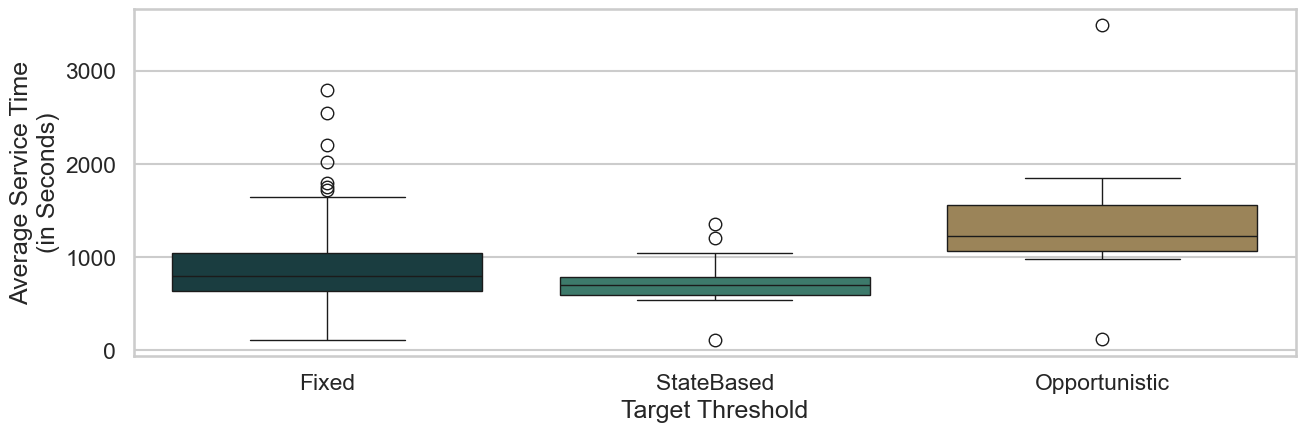

In [38]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(1600, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\886413577.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

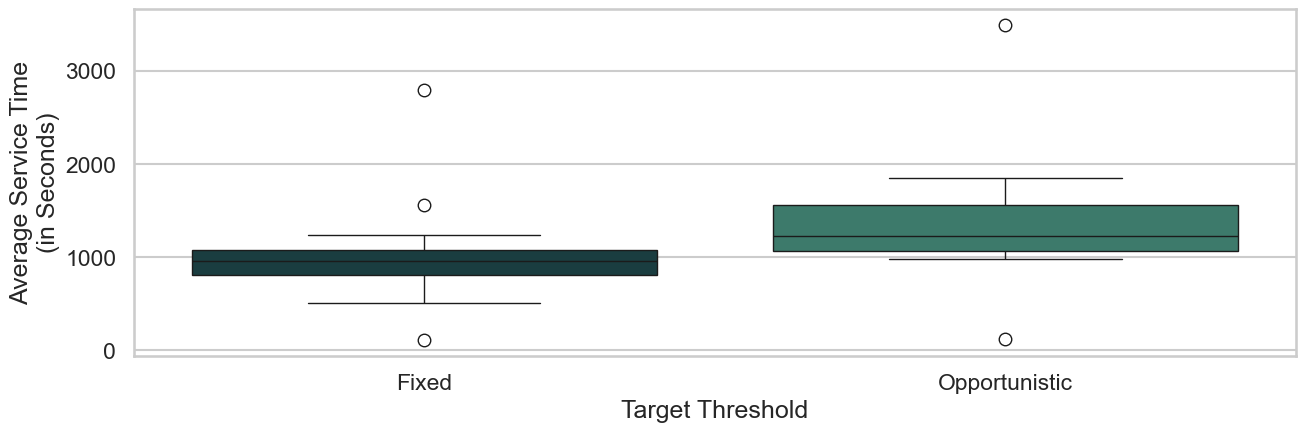

In [39]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False") & (df_paper["threshold"]=="th100")]
col_names = list(df_paper['GoChargingTH'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(1600, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\2094597658.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


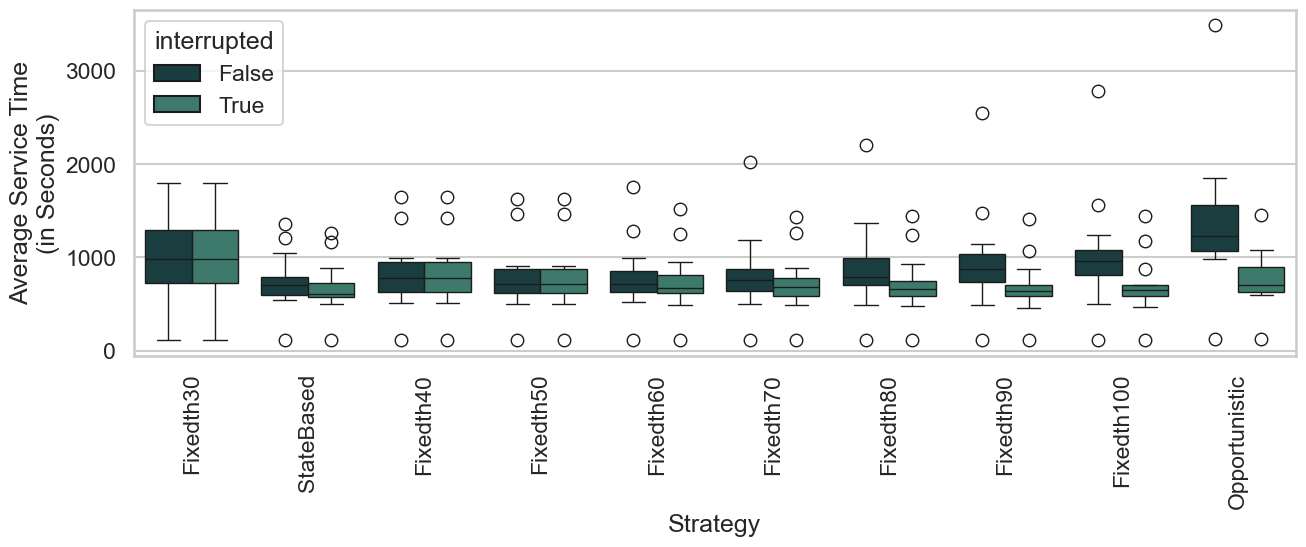

In [40]:
df = df_paper[(df_paper["go_charging"]!="PPO")] # & (df_paper["interrupted"]=="False")
col_names = list(df['GoChargingTH'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='GoChargingTH', y='average_service_time', data=df, palette=palette, hue="interrupted")
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Strategy")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(1600, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\2629349424.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


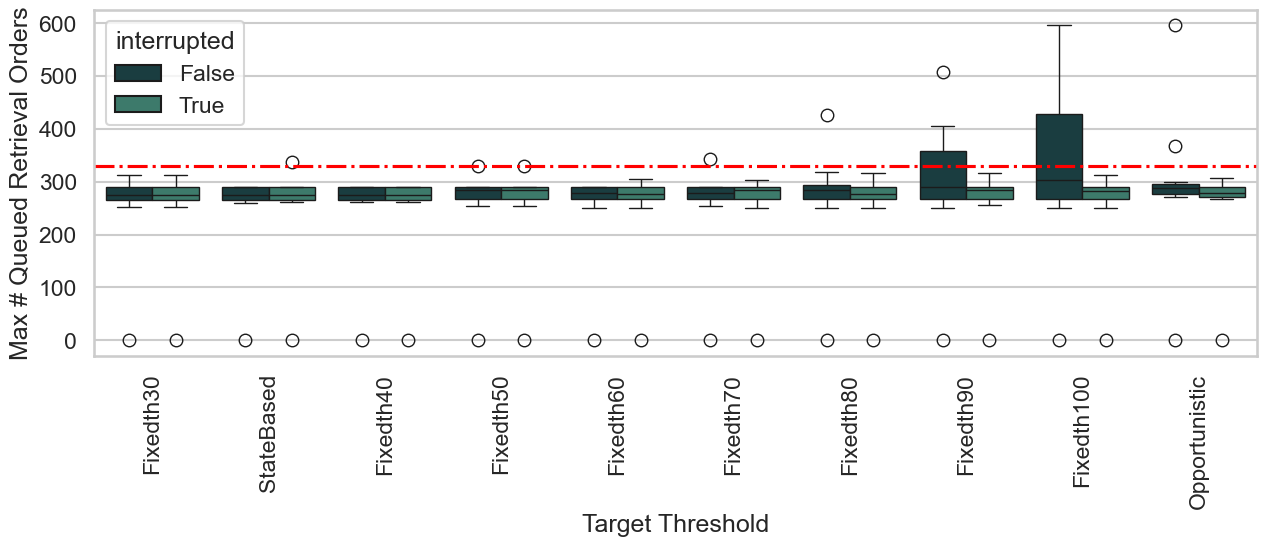

In [41]:
df = df_paper[(df_paper["go_charging"]!="PPO")] # & (df_paper["interrupted"]=="False")
col_names = list(df['GoChargingTH'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='GoChargingTH', y='max_retrieval_buffer', data=df, palette=palette, hue="interrupted")
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Max # Queued Retrieval Orders")
plt.savefig(f'{root_dir}/boxplot__queued_retrieval_thresholds_vs_interrupt_per_week.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'Max # Retrieval Queue')

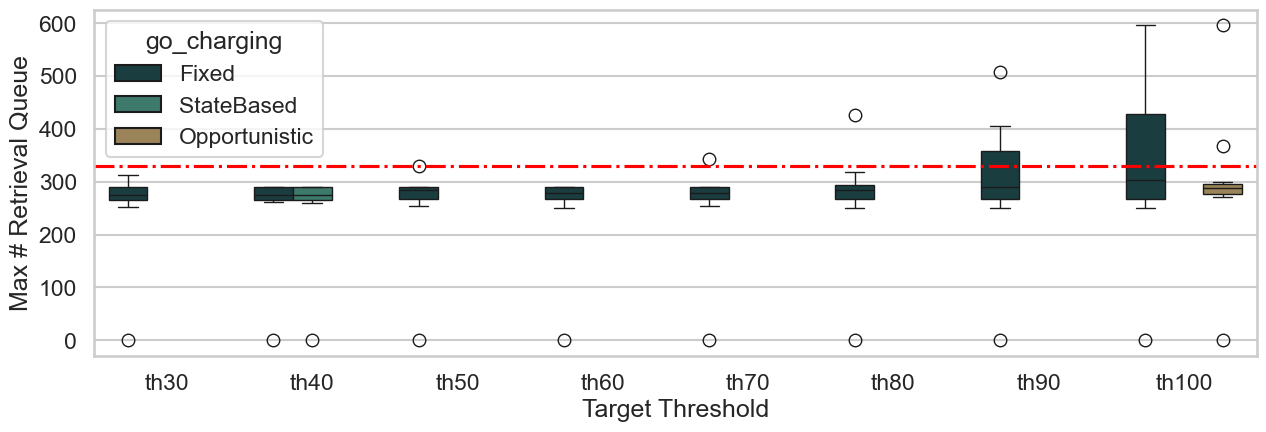

In [42]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='threshold', y='max_retrieval_buffer', data=df, palette=palette, hue="go_charging")
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Max # Retrieval Queue")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'Average Service Time\n(in Seconds)')

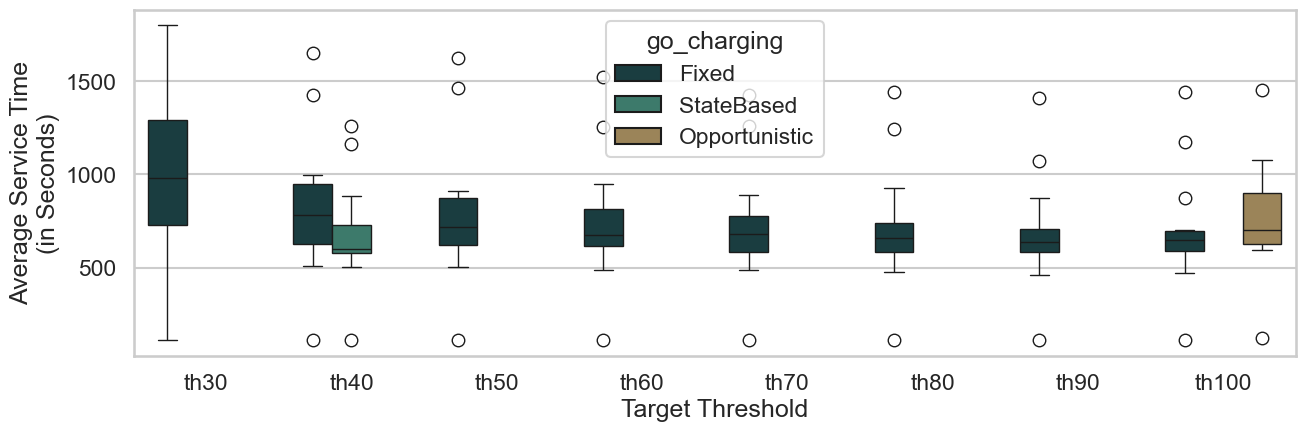

In [43]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="True")]
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='threshold', y='average_service_time', data=df, palette=palette, hue="go_charging")
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(1600, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\836439954.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='name', y='max_retrieval_buffer', data=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")], palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\836439954.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")].name.unique(), rotation=90)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

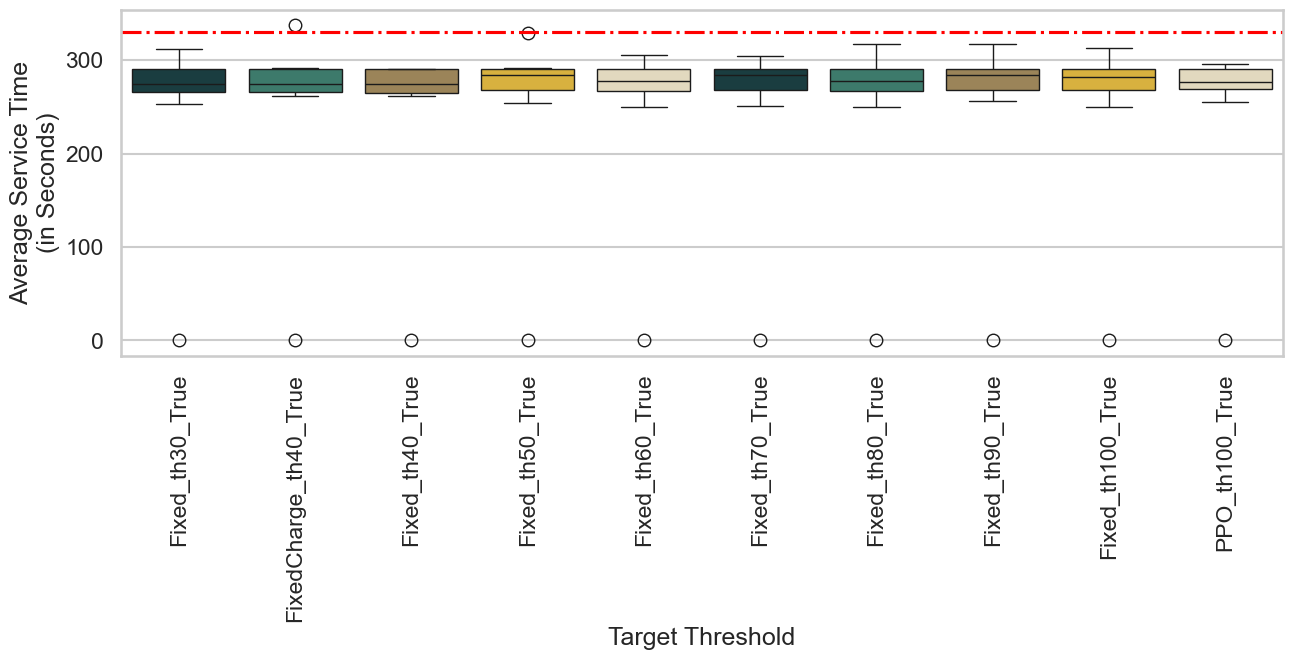

In [44]:
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='name', y='max_retrieval_buffer', data=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")], palette=palette)
ax.set_xticklabels(labels=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")].name.unique(), rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\546834414.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='name', y='average_service_time', data=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")], palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\546834414.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")].name.unique(), rotation=90)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

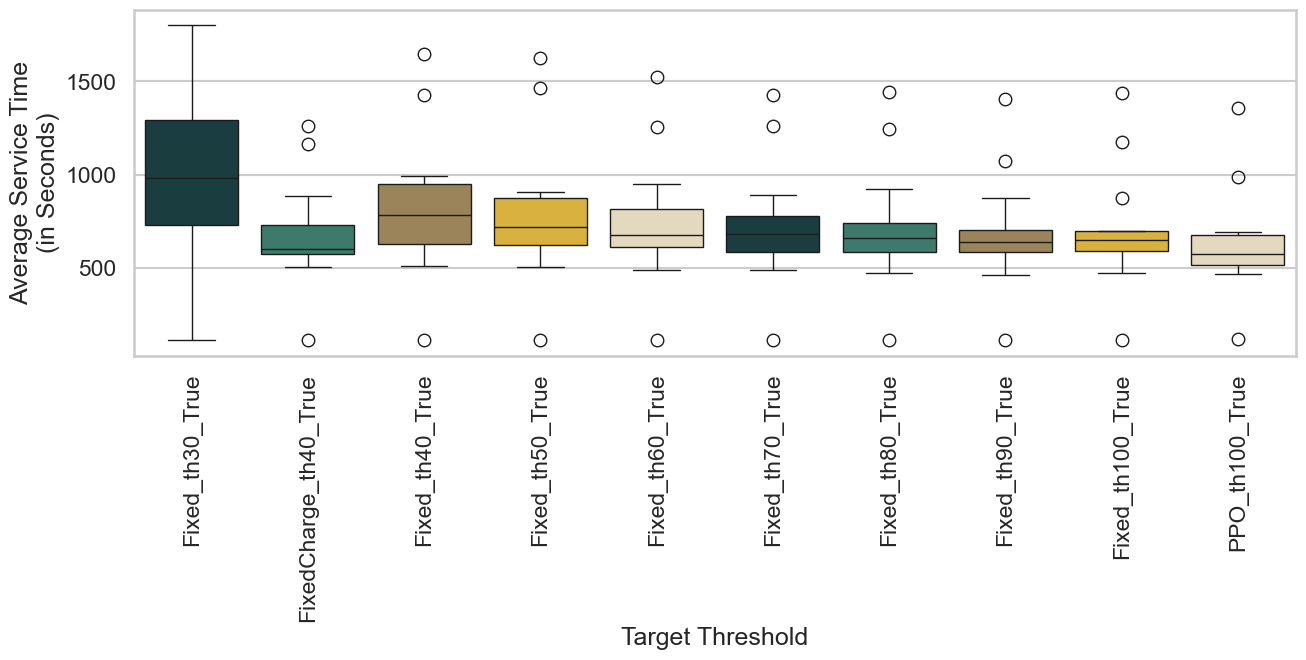

In [45]:
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='name', y='average_service_time', data=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")], palette=palette)
ax.set_xticklabels(labels=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")].name.unique(), rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

In [46]:
df_paper

,total_distance,total_shift_distance,distance_retrieval_ave,utilization_time,makespan,cycle_time,entropy,average_service_time,max_average_service_time,throughput,...,max_cs_queue,mean_cs_queue,mean_battery_level,index,name,go_charging,interrupted,threshold,week,GoChargingTH
1,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,1,Fixed_th30_False,Fixed,False,th30,0,Fixedth30
3,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,4,Fixed_th30_True,Fixed,True,th30,0,Fixedth30
4,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,6,FixedCharge_th40_False,StateBased,False,th40,0,StateBased
5,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,7,Fixed_th40_False,Fixed,False,th40,0,Fixedth40
6,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,9,FixedCharge_th40_True,StateBased,True,th40,0,StateBased
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,3437653.2,303402.4,176.895502,0.016133,7658654.3,4.691678e+06,0.670837,2210.485305,5038.679767,0.002459,...,31,4.531992,48.419058,31,Fixed_th80_False,Fixed,False,th80,13,Fixedth80
43,3457396.4,300053.6,178.731872,0.016138,7658632.4,4.602876e+06,0.666654,2546.992910,5802.512211,0.002459,...,31,4.716296,51.909117,37,Fixed_th90_False,Fixed,False,th90,13,Fixedth90
46,3464713.2,300000.4,178.268269,0.016158,7658177.8,4.707207e+06,0.659048,2790.589852,6607.419936,0.002459,...,34,4.639622,55.685263,43,Fixed_th100_False,Fixed,False,th100,13,Fixedth100
48,3498327.0,301263.2,178.932717,0.016195,7658443.1,4.704734e+06,0.677594,2952.731043,6607.419936,0.002459,...,34,5.219337,63.020953,45,PPO_th100_False,PPO,False,th100,13,PPOth100


In [47]:
df_paper.groupby(by=["name"]).agg({"average_service_time": "mean", "max_average_service_time": "max", "mean_battery_level": "mean", "max_retrieval_buffer": "max"})

,average_service_time,max_average_service_time,mean_battery_level,max_retrieval_buffer
name,,,,
FixedCharge_th40_False,741.247358,2517.792430,50.572020,290
FixedCharge_th40_True,679.235521,2517.792430,44.379486,337
Fixed_th100_False,1029.584940,6607.419936,59.433352,596
Fixed_th100_True,693.876762,2952.160785,49.372910,313
Fixed_th30_False,1019.441479,2796.541291,32.360532,312
Fixed_th30_True,1019.441479,2796.541291,32.360532,312
Fixed_th40_False,824.891714,2517.792430,36.229509,290
Fixed_th40_True,824.891714,2517.792430,36.229509,290
Fixed_th50_False,779.252231,3039.071882,40.142928,329


In [48]:
df_paper.groupby(by=["go_charging", "interrupted", "threshold"]).agg({"average_service_time": "mean", "max_average_service_time": "max", "mean_battery_level": "mean", "max_retrieval_buffer": "max"})

average_service_time  \
go_charging   interrupted threshold                         
Fixed         False       th100               1029.584940   
                          th30                1019.441479   
                          th40                 824.891714   
                          th50                 779.252231   
                          th60                 787.297362   
                          th70                 830.032485   
                          th80                 885.050034   
                          th90                 953.186348   
              True        th100                693.876762   
                          th30                1019.441479   
                          th40                 824.891714   
                          th50                 779.252231   
                          th60                 739.574698   
                          th70                 723.392698   
                          th80                 709.911485   
                          th90                 679.818180   
Opportunistic False       th100               1372.180033   
              True        th100                755.777888   
PPO           False       th100                868.388076   
              True        th100                626.828739   
StateBased    False       th40                 741.247358   
              True        th40                 679.235521   

                                     max_average_service_time  \
go_charging   interrupted threshold                             
Fixed         False       th100                   6607.419936   
                          th30                    2796.541291   
                          th40                    2517.792430   
                          th50                    3039.071882   
                          th60                    3574.032354   
                          th70                    4463.925669   
                          th80                    5038.679767   
                          th90                    5802.512211   
              True        th100                   2952.160785   
                          th30                    2796.541291   
                          th40                    2517.792430   
                          th50                    3039.071882   
                          th60                    3002.681399   
                          th70                    3000.478553   
                          th80                    3054.523651   
                          th90                    3024.801434   
Opportunistic False       th100                   6607.419936   
              True        th100                   2952.160785   
PPO           False       th100                   6607.419936   
              True        th100                   2952.160785   
StateBased    False       th40                    2517.792430   
              True        th40                    2517.792430   

                                     mean_battery_level  max_retrieval_buffer  
go_charging   interrupted threshold                                            
Fixed         False       th100               59.433352                   596  
                          th30                32.360532                   312  
                          th40                36.229509                   290  
                          th50                40.142928                   329  
                          th60                43.917492                   290  
                          th70                47.815857                   344  
                          th80                51.704775                   427  
                          th90                55.592086                   507  
              True        th100               49.372910                   313  
                          th30                32.360532                   312  
                          th40                36.22

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\1926284539.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\1926284539.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

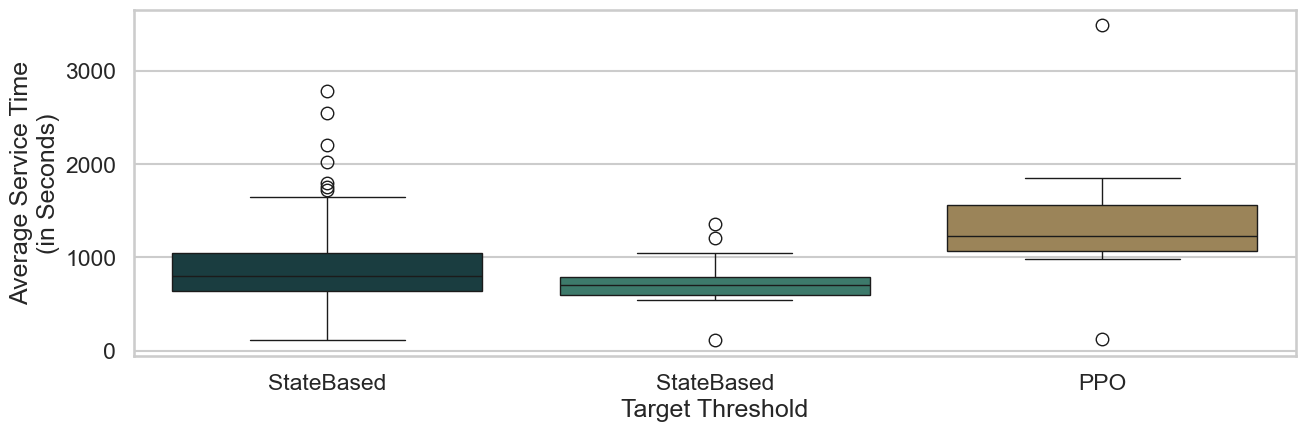

In [49]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['go_charging'].unique())
col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
ax.set_xticklabels(labels=col_names)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\3268636527.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='name', y='max_retrieval_buffer', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\3268636527.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

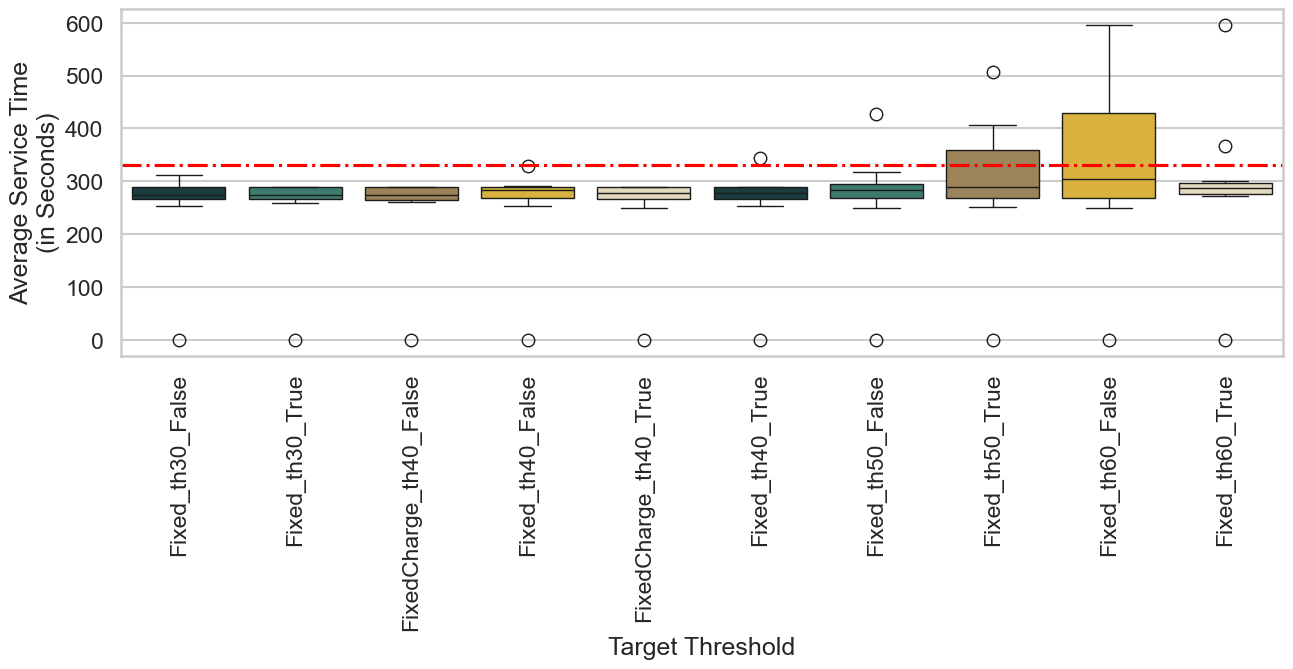

In [50]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['name'].unique())
# col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='name', y='max_retrieval_buffer', data=df, palette=palette)
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')

# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\2183095547.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='name', y='average_service_time', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\2183095547.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

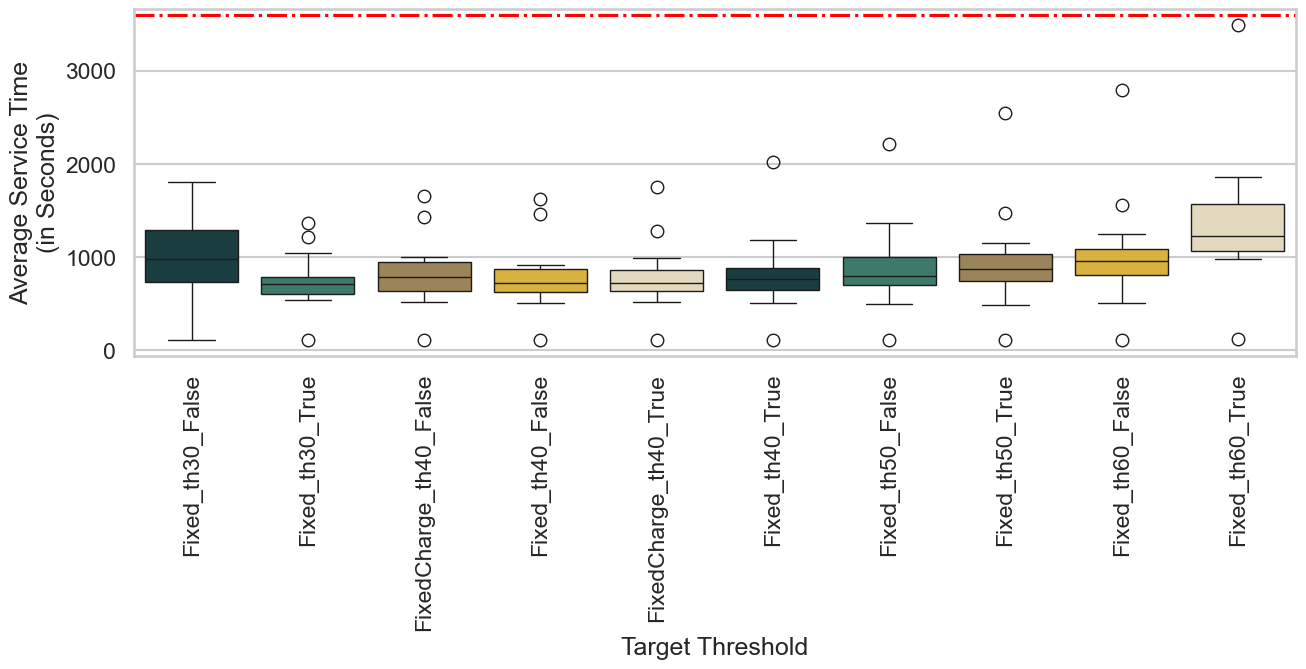

In [51]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['name'].unique())
# col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='name', y='average_service_time', data=df, palette=palette)
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
ax.axhline(3600, color='red', linestyle='dashdot', label='Limit')

# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'Average Service Time\n(in Seconds)')

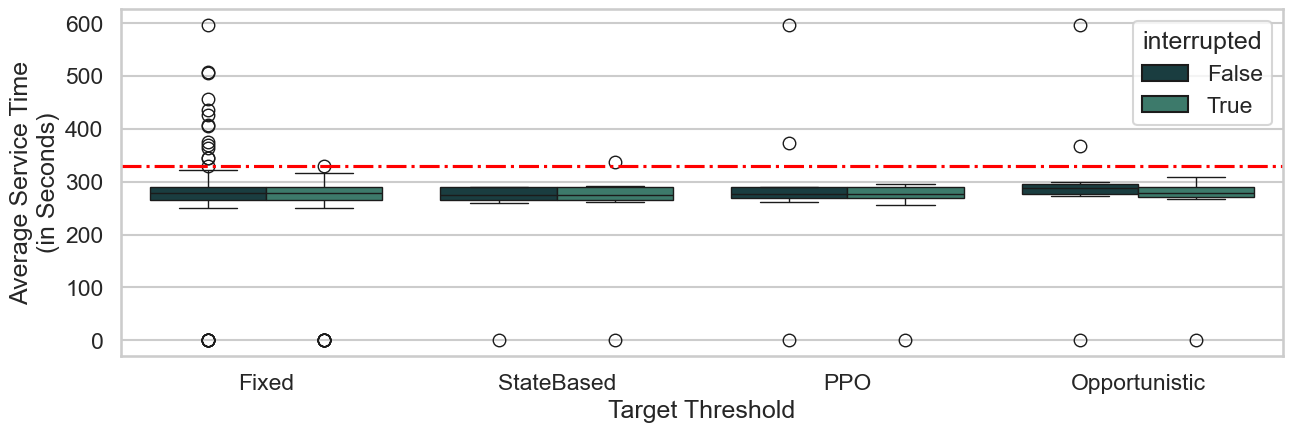

In [52]:
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='max_retrieval_buffer', data=df_paper, palette=palette, hue="interrupted")
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

In [53]:
df_paper

,total_distance,total_shift_distance,distance_retrieval_ave,utilization_time,makespan,cycle_time,entropy,average_service_time,max_average_service_time,throughput,...,max_cs_queue,mean_cs_queue,mean_battery_level,index,name,go_charging,interrupted,threshold,week,GoChargingTH
1,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,1,Fixed_th30_False,Fixed,False,th30,0,Fixedth30
3,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,4,Fixed_th30_True,Fixed,True,th30,0,Fixedth30
4,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,6,FixedCharge_th40_False,StateBased,False,th40,0,StateBased
5,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,7,Fixed_th40_False,Fixed,False,th40,0,Fixedth40
6,114048.2,0.0,0.000000,0.015718,104214.7,0.000000e+00,0.135804,109.936242,111.900000,0.005719,...,1,0.001678,92.289231,9,FixedCharge_th40_True,StateBased,True,th40,0,StateBased
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,3437653.2,303402.4,176.895502,0.016133,7658654.3,4.691678e+06,0.670837,2210.485305,5038.679767,0.002459,...,31,4.531992,48.419058,31,Fixed_th80_False,Fixed,False,th80,13,Fixedth80
43,3457396.4,300053.6,178.731872,0.016138,7658632.4,4.602876e+06,0.666654,2546.992910,5802.512211,0.002459,...,31,4.716296,51.909117,37,Fixed_th90_False,Fixed,False,th90,13,Fixedth90
46,3464713.2,300000.4,178.268269,0.016158,7658177.8,4.707207e+06,0.659048,2790.589852,6607.419936,0.002459,...,34,4.639622,55.685263,43,Fixed_th100_False,Fixed,False,th100,13,Fixedth100
48,3498327.0,301263.2,178.932717,0.016195,7658443.1,4.704734e+06,0.677594,2952.731043,6607.419936,0.002459,...,34,5.219337,63.020953,45,PPO_th100_False,PPO,False,th100,13,PPOth100


# RL Results

In [54]:
rl_runs = {
    "R1": "hmdjfs33",
    "R2": "3x71b390",
    # "R3": "",
    "R4": "umgysp3e",
    "R5": "qm61th79"
}

In [55]:
# run = api.run(f"{entity}/{project}/runs/{run_id}")

In [70]:
rl_rewards = pd.DataFrame()
for run_name in rl_runs:
    run = api.run(f"{entity}/{project}/runs/{rl_runs[run_name]}")
    key_reward = f"rollout/ep_rew_mean"
    reward_df = run.history(keys=[key_reward])
    reward_df["reward_setting"] = run_name
    reward_df.rename(columns={key_reward: "mean_ep_reward", "_step": "step"}, inplace=True)
    rl_rewards = pd.concat([rl_rewards, reward_df], ignore_index=True)

In [71]:
rl_results = pd.DataFrame()
df_rl_actions = pd.DataFrame()
for run_name in rl_runs:
    run = api.run(f"{entity}/{project}/runs/{rl_runs[run_name]}")
    for i in range(n_partitions):
        row = {
            'total_distance': 0,
            'total_shift_distance': 0,
            'distance_retrieval_ave': 0,
            'utilization_time': 0,
            'makespan': 0,
            'cycle_time': 0,
            'entropy': 0,
            'average_service_time': 0,
            'max_average_service_time': 0,
            'throughput': 0,
            'max_delivery_buffer': 0,
            'max_retrieval_buffer': 0,
            'mean_retrieval_buffer': 0,
            'max_agv_depleted': 0,
            'mean_agv_depleted': 0,
            'max_cs_queue': 0,
            'mean_cs_queue': 0,
            'mean_battery_level': 0,
            'index': 0,
            'name': 0,
            'go_charging': 0,
            'interrupted': 0,
            'threshold': 0
        }
        key_service_time = f"logs/Evaluation/{i}/Servicetime"
        key_retrieval_orders = f"logs/Evaluation/{i}/N_Retrieval_Orders"
        key_battery = f"logs/Evaluation/{i}/Avg_Battery_Level"
        key_action = f"logs/Evaluation/{i}/Action"
        
        st_df = run.history(keys=[key_service_time])
        st_df["reward_setting"] = run_name
        st_df["week"] = i
        st_df.drop("_step", axis=1, inplace=True)
        st_df.rename(columns={key_service_time: "average_service_time"}, inplace=True)
        
        ret_df = run.history(keys=[key_retrieval_orders])
        ret_df["reward_setting"] = run_name
        ret_df["week"] = i
        ret_df.drop("_step", axis=1, inplace=True)
        ret_df.rename(columns={key_retrieval_orders: "queued_retrieval_orders"}, inplace=True)
        
        battery_df = run.history(keys=[key_battery])
        battery_df["reward_setting"] = run_name
        battery_df["week"] = i
        battery_df.drop("_step", axis=1, inplace=True)
        battery_df.rename(columns={key_battery: "mean_battery_level"}, inplace=True)
        
        action_df = run.history(keys=[key_action])
        action_df["reward_setting"] = run_name
        action_df["week"] = i
        action_df.drop("_step", axis=1, inplace=True)
        action_df.rename(columns={key_action: "action"}, inplace=True)
        
        df_rl_actions = pd.concat([df_rl_actions, action_df], ignore_index=True)
        row["average_service_time"] = st_df["average_service_time"].iloc[-1]
        row["max_average_service_time"] = st_df["average_service_time"].max()
        row["max_retrieval_buffer"] = ret_df["queued_retrieval_orders"].max()
        row["mean_retrieval_buffer"] = ret_df["queued_retrieval_orders"].mean()
        row["mean_battery_level"] = battery_df["mean_battery_level"].mean()
        row["index"] = i
        row["go_charging"] = f"PPO_{run_name}"
        row["interrupted"] = "False"
        row["threshold"] = "All"
        df_row = pd.DataFrame([row])  
        rl_results = pd.concat([rl_results, df_row], ignore_index=True)
    

In [72]:
rl_rewards 

,step,mean_ep_reward,reward_setting
0,39714.0,-36260.07400,R1
1,58174.0,-36260.07400,R1
2,72293.0,-36260.07400,R1
3,74176.0,-36260.07400,R1
4,82609.0,-32942.40200,R1
...,...,...,...
1995,4004960.0,-690.78064,R5
1996,4007144.0,-690.10780,R5
1997,4011499.0,-690.10780,R5
1998,4019354.0,-690.10780,R5


C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\2918880551.py:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.lineplot(ax=ax, x="step", y="mean_ep_reward", data=rl_rewards, palette=pal, hue="reward_setting")


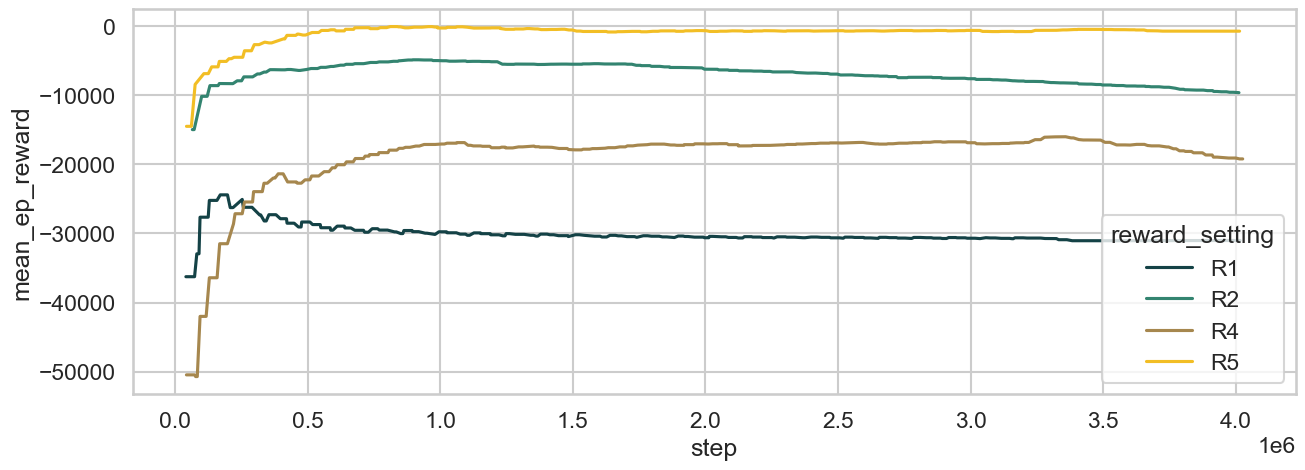

In [59]:
_, ax = plt.subplots(figsize=(15, 5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle([pal])
ax = sns.lineplot(ax=ax, x="step", y="mean_ep_reward", data=rl_rewards, palette=pal, hue="reward_setting")
plt.savefig(f'{root_dir}/ppo_ep_rewards.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\485983971.py:15: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.lineplot(


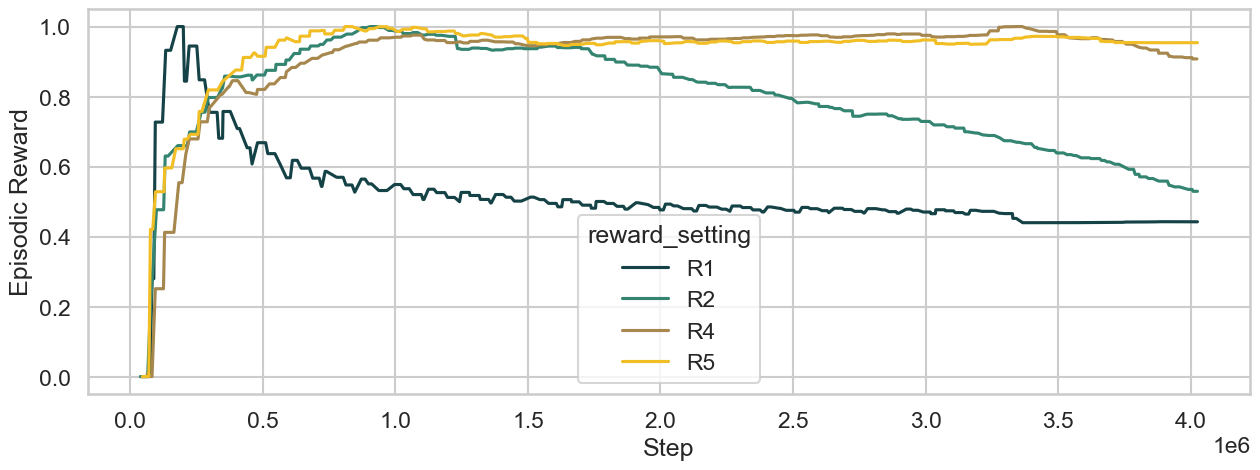

In [74]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the mean_ep_reward column for each reward setting
rl_rewards['scaled_reward'] = rl_rewards.groupby('reward_setting')['mean_ep_reward'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Plot scaled rewards
_, ax = plt.subplots(figsize=(15, 5))
ax.ticklabel_format(axis='x', style='sci')
ax = sns.lineplot(
    ax=ax,
    x="step",
    y="scaled_reward",
    data=rl_rewards,
    palette=pal,
    hue="reward_setting"
)
ax.set_xlabel("Step")
ax.set_ylabel("Episodic Reward")
plt.savefig(f'{root_dir}/ppo_scaled_rewards.png', dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\1518020170.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\1518020170.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


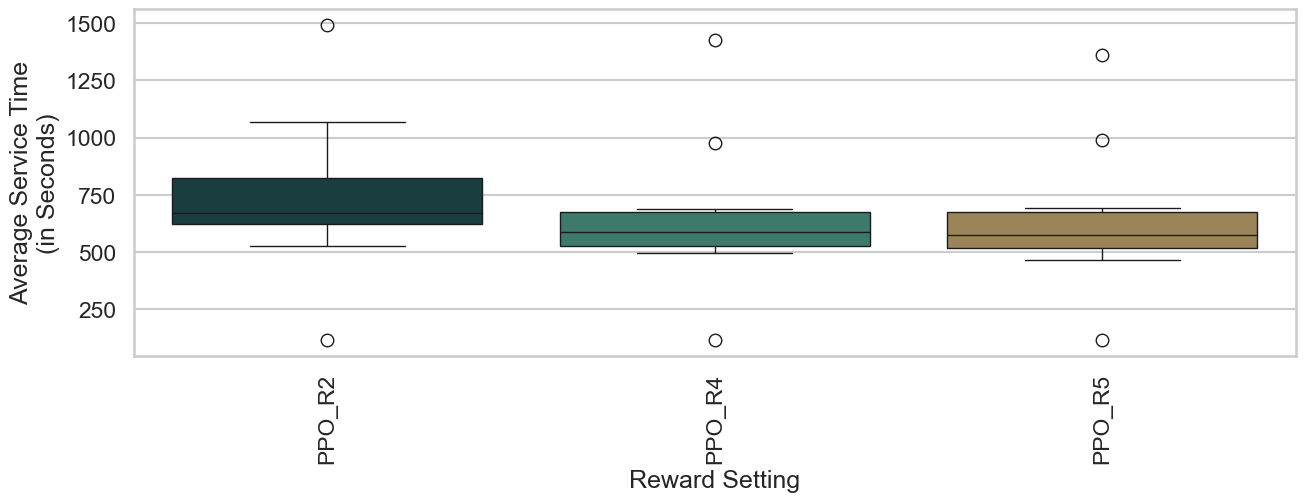

In [60]:
df = rl_results[rl_results["go_charging"] != "PPO_R1"]
col_names = list(df['go_charging'].unique())
# col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Reward Setting")
# ax.axhline(3600, color='red', linestyle='dashdot', label='Limit')

# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_ppo_rewards.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\2859838622.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='max_retrieval_buffer', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_8704\2859838622.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


Text(0, 0.5, 'Max # Retrieval Queue')

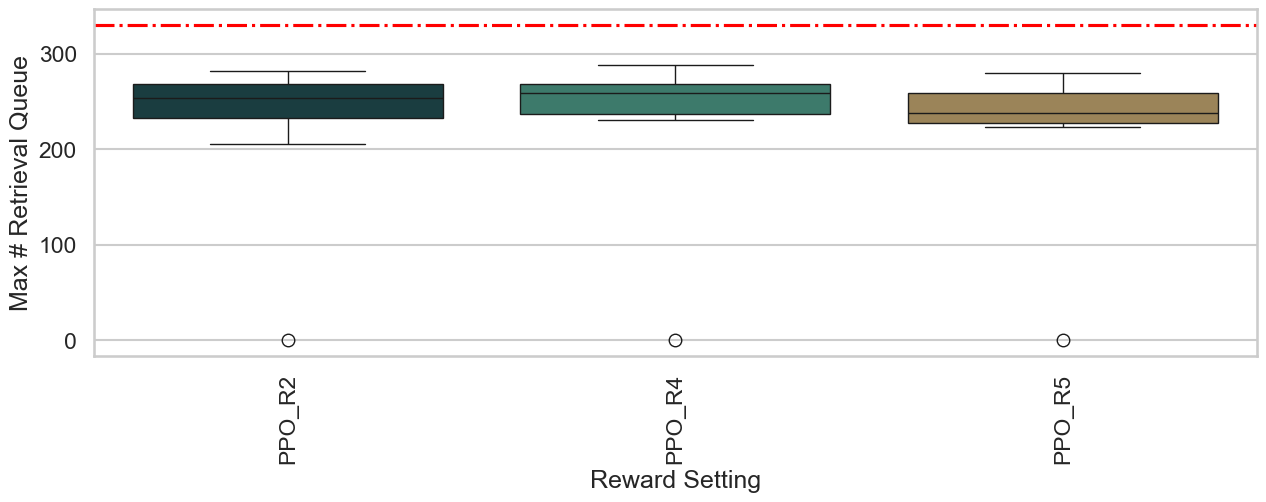

In [61]:
df = rl_results[rl_results["go_charging"] != "PPO_R1"]
col_names = list(df['go_charging'].unique())
# col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='max_retrieval_buffer', data=df, palette=palette)
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Reward Setting")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')

# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Max # Retrieval Queue")
# plt.savefig(f'{root_dir}/boxplot__kpi__queued_retrieval_orders_ppo_rewards.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

In [62]:
df_rl_actions

,action,reward_setting,week
0,8,R1,0
1,8,R1,0
2,8,R1,0
3,8,R1,0
4,8,R1,0
...,...,...,...
27995,0,R5,13
27996,0,R5,13
27997,1,R5,13
27998,0,R5,13


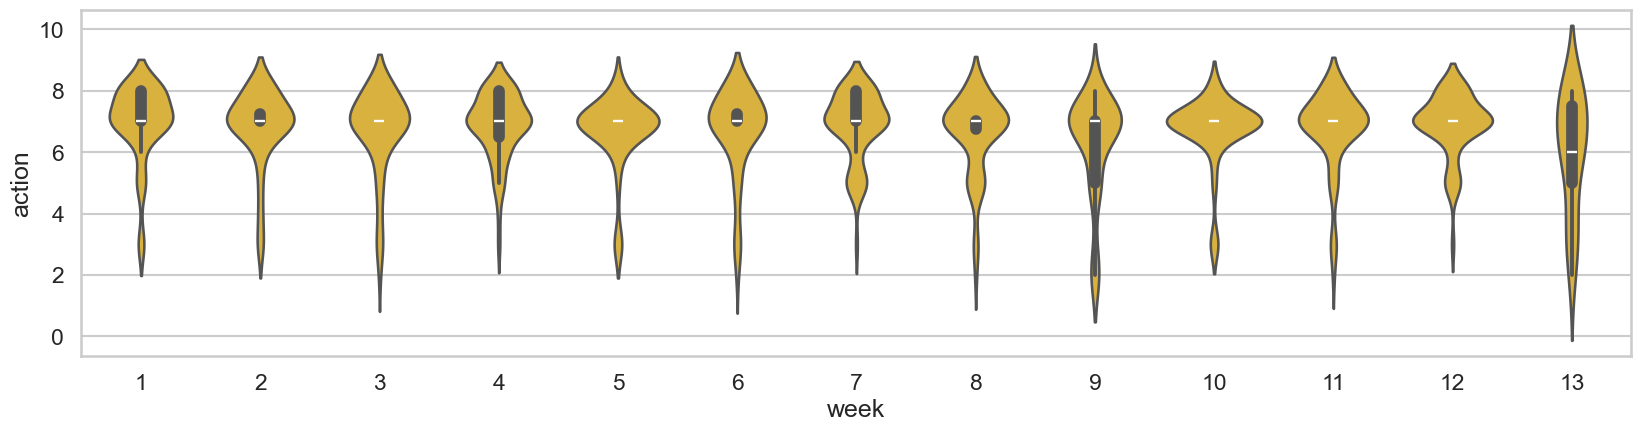

In [63]:
_, ax = plt.subplots(figsize=(20, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle([pal[0], pal[3]])
ax = sns.violinplot(ax=ax, x="week", y="action", data=df_rl_actions[(df_rl_actions["reward_setting"]=="R4") & (df_rl_actions["action"]!=0) & (df_rl_actions["week"]!=0)], color=pal[3])

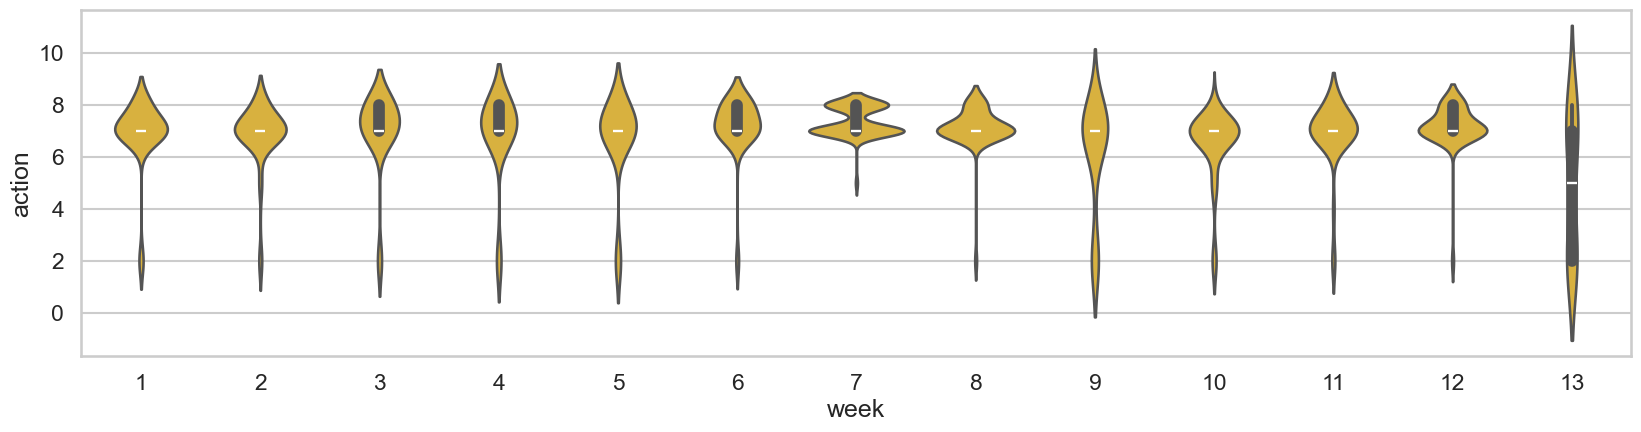

In [64]:
_, ax = plt.subplots(figsize=(20, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle([pal[0], pal[3]])
ax = sns.violinplot(ax=ax, x="week", y="action", data=df_rl_actions[(df_rl_actions["reward_setting"]=="R2") & (df_rl_actions["action"]!=0) & (df_rl_actions["week"]!=0)], color=pal[3])

In [65]:
rl_results_grouped = rl_results.groupby(by="go_charging").agg({"average_service_time": "mean", "max_average_service_time": "max", "max_retrieval_buffer": "max", "mean_retrieval_buffer": "mean", "mean_battery_level": "mean"})

In [66]:
df_heuristics_grouped = df_paper.groupby(by="name").agg({"average_service_time": "mean", 
                                                         "max_average_service_time": "max",
                                                         "max_retrieval_buffer": "max", "mean_retrieval_buffer": "mean", "mean_battery_level": "mean"}).reset_index()
df_heuristics_grouped = df_heuristics_grouped[df_heuristics_grouped["name"] != "PPO_th100_True"]
df_heuristics_3best = df_heuristics_grouped.sort_values(by=["average_service_time", "max_retrieval_buffer"]).head(3)
df_heuristics_3worst = df_heuristics_grouped.sort_values(by=["average_service_time", "max_retrieval_buffer"], ascending=False).head(3)

In [67]:
pd.concat([df_heuristics_3best, df_heuristics_3worst, rl_results_grouped]).sort_values(by=["average_service_time", "max_retrieval_buffer"])#.to_latex()

,name,average_service_time,max_average_service_time,max_retrieval_buffer,mean_retrieval_buffer,mean_battery_level
PPO_R5,NaN,628.315497,2949.230700,280,21.273286,61.919158
PPO_R4,NaN,641.941846,3093.442400,288,21.723286,60.094988
1,FixedCharge_th40_True,679.235521,2517.792430,337,21.986172,44.379486
17,Fixed_th90_True,679.818180,3024.801434,317,22.451649,47.753467
3,Fixed_th100_True,693.876762,2952.160785,313,22.531734,49.372910
PPO_R2,NaN,730.189343,2875.150600,282,24.168714,65.187500
4,Fixed_th30_False,1019.441479,2796.541291,312,30.150117,32.360532
2,Fixed_th100_False,1029.584940,6607.419936,596,30.221158,59.433352
18,Opportunistic_th100_False,1372.180033,6607.419936,596,42.041669,76.447299
PPO_R1,NaN,5396.428166,9803.149000,970,169.122286,55.033931


In [68]:
# Compute both mean and std in the groupby
df_paper["total_distance"] = (df_paper["total_distance"] / 1000) / 40
df_heuristics_grouped = df_paper.groupby(by="name").agg({
    "average_service_time": ["mean", "std"], 
    "max_average_service_time": "max",
    "max_retrieval_buffer": ["max", "std"],
    "mean_retrieval_buffer": ["mean", "std"],
    "mean_battery_level": ["mean", "std"],
    "total_distance": ["mean", "std"]
}).reset_index()

# Flatten multi-level column names
df_heuristics_grouped.columns = [
    'name',
    'avg_service_time_mean', 'avg_service_time_std',
    'max_service_time',
    'max_retrieval_buffer_max', 'max_retrieval_buffer_std',
    'mean_retrieval_buffer_mean', 'mean_retrieval_buffer_std',
    'mean_battery_level_mean', 'mean_battery_level_std',
    'total_distance_mean', 'total_distance_std'
]

# Create formatted strings with mean ± std
df_heuristics_grouped['avg_service_time_formatted'] = df_heuristics_grouped.apply(
    lambda row: f"{row['avg_service_time_mean']:.2f} ± {row['avg_service_time_std']:.2f}", axis=1
)
df_heuristics_grouped['mean_retrieval_buffer_formatted'] = df_heuristics_grouped.apply(
    lambda row: f"{row['mean_retrieval_buffer_mean']:.2f} ± {row['mean_retrieval_buffer_std']:.2f}", axis=1
)
df_heuristics_grouped['mean_battery_level_formatted'] = df_heuristics_grouped.apply(
    lambda row: f"{row['mean_battery_level_mean']:.2f} ± {row['mean_battery_level_std']:.2f}", axis=1
)
df_heuristics_grouped['mean_distance_formatted'] = df_heuristics_grouped.apply(
    lambda row: f"{row['total_distance_mean']:.2f} ± {row['total_distance_std']:.2f}", axis=1
)
# For sorting, we'll still use the mean values
df_heuristics_3best = df_heuristics_grouped[df_heuristics_grouped["name"] != "PPO_th100_True"].sort_values(
    by=["avg_service_time_mean", "max_retrieval_buffer_max"]
).head(3)

df_heuristics_3worst = df_heuristics_grouped[df_heuristics_grouped["name"] != "PPO_th100_True"].sort_values(
    by=["avg_service_time_mean", "max_retrieval_buffer_max"], 
    ascending=False
).head(3)

# To display the results with mean ± std, use the formatted columns
display_columns = [
    'name', 
    'avg_service_time_formatted', 
    'max_service_time',
    'max_retrieval_buffer_max', 
    'mean_retrieval_buffer_formatted',
    'mean_battery_level_formatted',
    'mean_distance_formatted',
]

print("\nBest performing strategies:")
print(df_heuristics_3best[display_columns])

print("\nWorst performing strategies:")
print(df_heuristics_3worst[display_columns])


Best performing strategies:
                     name avg_service_time_formatted  max_service_time  \
1   FixedCharge_th40_True            679.24 ± 283.41       2517.792430   
17        Fixed_th90_True            679.82 ± 299.56       3024.801434   
3        Fixed_th100_True            693.88 ± 315.41       2952.160785   

    max_retrieval_buffer_max mean_retrieval_buffer_formatted  \
1                        337                    21.99 ± 7.78   
17                       317                    22.45 ± 8.94   
3                        313                    22.53 ± 9.08   

   mean_battery_level_formatted mean_distance_formatted  
1                 44.38 ± 14.11          137.00 ± 44.19  
17                47.75 ± 12.92          136.09 ± 43.87  
3                 49.37 ± 12.54          135.81 ± 43.71  

Worst performing strategies:
                         name avg_service_time_formatted  max_service_time  \
18  Opportunistic_th100_False           1372.18 ± 731.49       6607.419936   

In [77]:
def create_latex_table(df):
    latex_table = """\\begin{table}[!h]
\\setlength{\\tabcolsep}{2pt}
\\renewcommand{\\arraystretch}{1.2}
\\scriptsize
\\begin{tabularx}{\\textwidth}{
>{\\raggedright\\arraybackslash}p{2cm}CCCCCCC}
\\toprule
\\multirow{2}{*}{\\textbf{Strategy}}& \\textbf{Avg Service Time (in s)} & \\textbf{Max Retrieval Queue} & \\textbf{Mean Retrieval Queue} & \\textbf{Mean Battery Level} & \\textbf{Mean Travel Distance (km)}\\\\[6pt]
\\midrule
"""
    
    for _, row in df[display_columns].iterrows():
        # Ensure fixed width for service time values using \phantom
        service_time = row['avg_service_time_formatted'].split('±')
        service_time_formatted = f"{{\\phantom{{0}}{service_time[0].strip()} ± {service_time[1].strip()}}}"
        
        latex_table += f"""\\textbf{{{row['name']}}} & \\makecell[c]{{{service_time_formatted}}} & \\makecell[c]{{{row['max_retrieval_buffer_max']}}} & \\makecell[c]{{{row['mean_retrieval_buffer_formatted']}}} & \\makecell[c]{{{row['mean_battery_level_formatted']}}} & \\makecell[c]{{{row['mean_distance_formatted']}}} \\\\\n"""
    
    latex_table += """\\bottomrule
\\end{tabularx}
\\caption{\\small Comparison of different charging strategies and their performance metrics}
\\label{tab:charging_results}
\\end{table}"""
    
    return latex_table

latex_table = create_latex_table(pd.concat([df_heuristics_3best[display_columns], df_heuristics_3worst[display_columns]]))
print(latex_table)

\begin{table}[!h]
\setlength{\tabcolsep}{2pt}
\renewcommand{\arraystretch}{1.2}
\scriptsize
\begin{tabularx}{\textwidth}{
>{\raggedright\arraybackslash}p{2cm}CCCCCCC}
\toprule
\multirow{2}{*}{\textbf{Strategy}}& \textbf{Avg Service Time (in s)} & \textbf{Max Retrieval Queue} & \textbf{Mean Retrieval Queue} & \textbf{Mean Battery Level} & \textbf{Mean Travel Distance (km)}\\[6pt]
\midrule
\textbf{FixedCharge_th40_True} & \makecell[c]{{\phantom{0}679.24 ± 283.41}} & \makecell[c]{337} & \makecell[c]{21.99 ± 7.78} & \makecell[c]{44.38 ± 14.11} & \makecell[c]{137.00 ± 44.19} \\
\textbf{Fixed_th90_True} & \makecell[c]{{\phantom{0}679.82 ± 299.56}} & \makecell[c]{317} & \makecell[c]{22.45 ± 8.94} & \makecell[c]{47.75 ± 12.92} & \makecell[c]{136.09 ± 43.87} \\
\textbf{Fixed_th100_True} & \makecell[c]{{\phantom{0}693.88 ± 315.41}} & \makecell[c]{313} & \makecell[c]{22.53 ± 9.08} & \makecell[c]{49.37 ± 12.54} & \makecell[c]{135.81 ± 43.71} \\
\textbf{Opportunistic_th100_False} & \makecell[c]{{\p

In [ ]:
df_heuristics_3best[display_columns]

In [ ]:
df_paper.groupby(by="name").agg({"average_service_time": "mean", 
                                                         "max_average_service_time": "max",
                                                         "max_retrieval_buffer": "max", "mean_retrieval_buffer": "mean", "mean_battery_level": "mean",
                                 "total_distance": "mean"}).reset_index()

In [ ]:
from copy import deepcopy

def plot_constraints(indicator, limit, df):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    xlim = 0
    # for th in reversed(list(dfs_d.keys())):
    #     for df in dfs_d[th]:
    #         if df.strategy_name[0] == "COL":
    #             df_parametrization_check = deepcopy(df)
    #             samples = df_parametrization_check.sample(min(500,df_parametrization_check.shape[0]))
    #             #if n_agv == 7:
    #             #    xlim = df_parametrization_check['kpi__makespan'].max() 
    #             #    print(xlim)
    #             ax = sns.lineplot(
    #                 ax=ax, x=samples['kpi__makespan'], y=samples[indicator], 
    #                 label=th, color=next(palette))
    
    
    ax = sns.lineplot(
                    ax=ax, x=df.index, y=df["mean_battery_level"], 
                    label="")
    # ax.axhline(limit, 
    #            color='red', linestyle='dashdot', label='Limit') 

    ax.legend(title='Threshold')
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    ax.set_ylabel('Average Service Time\n(in Seconds)')

    # plt.savefig(f'{root_dir}/constraints__{indicator}.png', 
    #             dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

plot_constraints('kpi__average_service_time', limit=600, df=battery_df[battery_df["reward_setting"]=="R2"])
# plot_constraints('n_queued_retrieval_orders', limit=693)
# plot_constraints('n_queued_delivery_orders', limit=693)
# plot_constraints('avg_battery_level', limit=100)

In [ ]:
battery_df

In [ ]:
battery_df[battery_df["reward_setting"]=="R5"]

In [ ]:
dfs_d